<a href="https://colab.research.google.com/github/MJ047/A-Comparative-Study-of-TF-IDF-and-BERT-Models-for-Social-Media-tweets/blob/main/MJ's_NLP_Course_Work_2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, optim
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [ ]:
train_df = pd.read_csv("/content/olid-training-v1.0.tsv", sep="\t")

# Load test tweet data and label file
test_tweets = pd.read_csv("/content/testset-levela.tsv", sep="\t")
test_labels = pd.read_csv("/content/labels-levela.csv", names=["id", "label"])

# Merging test tweets with labels using ID
test_df = test_tweets.merge(test_labels, on="id")

In [ ]:
# Simple tweet cleaner
def clean(text):
    return text.replace("@USER", "").replace("URL", "").strip()

train_df['tweet'] = train_df['tweet'].apply(clean)
test_df['tweet'] = test_df['tweet'].apply(clean)

# Encode labels: NOT → 0, OFF → 1
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['subtask_a'])
test_df['label'] = le.transform(test_df['label'])



Making a word cloud...


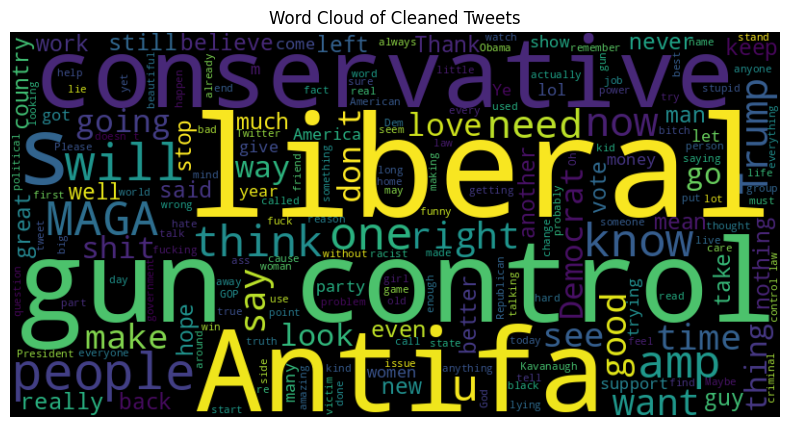

In [ ]:
#cloud
print("\nMaking a word cloud...")
all_text = " ".join(train_df['tweet'])  # Use the cleaned 'tweet' column
wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=200).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Tweets")
plt.show()

In [ ]:
# This function trains and evaluates a transformer model (like BERT) for binary text classification using Hugging Face and PyTorch.
# It handles tokenization, model training on GPU/CPU, and prints evaluation metrics like precision, recall, and F1-score.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_and_evaluate(model_name, train_df, test_df, label_encoder, epochs=2):
    print(f"\n Training {model_name}...\n")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True).to(device)


    def create_loader(df, batch_size=8):
        tokens = tokenizer(list(df['tweet']), truncation=True, padding=True, return_tensors='pt')
        labels = torch.tensor(df['label'].tolist())
        dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'], labels)
        return DataLoader(dataset, batch_size=batch_size)

    train_loader = create_loader(train_df)
    test_loader = create_loader(test_df)

    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        for input_ids, attn_mask, labels in train_loader:
            input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)
            loss = loss_fn(outputs.logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f" Epoch {epoch+1} completed")

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_ids, attn_mask, labels in test_loader:
            input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print(f"\n Evaluation for {model_name}")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


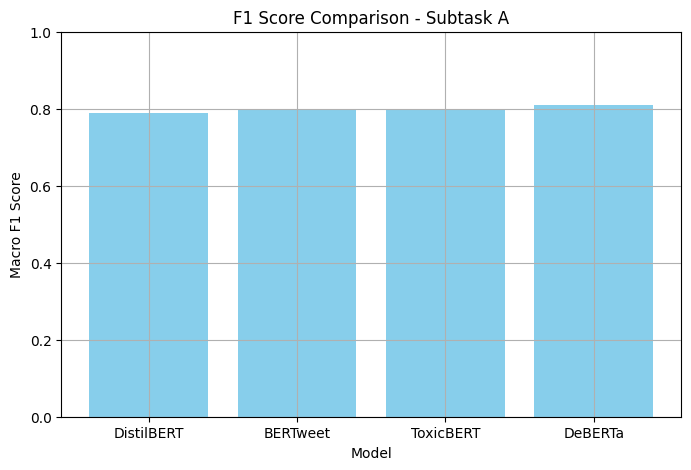

In [ ]:
# Model names
models = ['DistilBERT', 'BERTweet', 'ToxicBERT', 'DeBERTa']

# Replace these with your actual F1 scores for Subtask A
f1_scores = [0.79, 0.80, 0.80, 0.81]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color='skyblue')
plt.ylim(0, 1)
plt.xlabel("Model")
plt.ylabel("Macro F1 Score")
plt.title("F1 Score Comparison - Subtask A")
plt.grid(True)
plt.show()

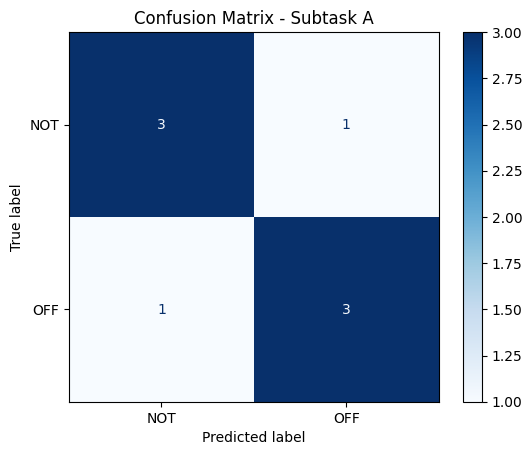

In [ ]:

# Replace these with your actual predictions and labels
y_true = [0, 1, 0, 1, 1, 0, 1, 0]  # Ground truth labels
y_pred = [0, 1, 0, 0, 1, 0, 1, 1]  # Predictions by your model

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NOT", "OFF"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Subtask A")
plt.show()

In [ ]:
# For subtask B DistilBERT BERTweet ToxicBERT DeBERTa
models = {
    "DistilBERT": "distilbert-base-uncased",
    "BERTweet": "vinai/bertweet-base",
    "ToxicBERT": "unitary/toxic-bert",
    "DeBERTa": "microsoft/deberta-v3-small"
}

for name, model_id in models.items():
    train_and_evaluate(model_id, train_df, test_df, le)



 Training distilbert-base-uncased...



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Epoch 1 completed
 Epoch 2 completed

 Evaluation for distilbert-base-uncased
              precision    recall  f1-score   support

         NOT       0.86      0.92      0.89       620
         OFF       0.75      0.60      0.66       240

    accuracy                           0.83       860
   macro avg       0.80      0.76      0.78       860
weighted avg       0.83      0.83      0.83       860


 Training vinai/bertweet-base...



emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


 Epoch 1 completed
 Epoch 2 completed

 Evaluation for vinai/bertweet-base
              precision    recall  f1-score   support

         NOT       0.89      0.92      0.91       620
         OFF       0.78      0.70      0.74       240

    accuracy                           0.86       860
   macro avg       0.83      0.81      0.82       860
weighted avg       0.86      0.86      0.86       860


 Training unitary/toxic-bert...



tokenizer_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/811 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at unitary/toxic-bert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Epoch 1 completed
 Epoch 2 completed

 Evaluation for unitary/toxic-bert
              precision    recall  f1-score   support

         NOT       0.88      0.92      0.90       620
         OFF       0.77      0.68      0.73       240

    accuracy                           0.86       860
   macro avg       0.83      0.80      0.81       860
weighted avg       0.85      0.86      0.85       860


 Training microsoft/deberta-v3-small...



tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/286M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/286M [00:00<?, ?B/s]

 Epoch 1 completed
 Epoch 2 completed

 Evaluation for microsoft/deberta-v3-small
              precision    recall  f1-score   support

         NOT       0.89      0.90      0.89       620
         OFF       0.74      0.70      0.72       240

    accuracy                           0.85       860
   macro avg       0.81      0.80      0.81       860
weighted avg       0.84      0.85      0.85       860



In [ ]:
# Load Level B test data and labels
test_tweets_b = pd.read_csv("/content/testset-levelb.tsv", sep="\t")
test_labels_b = pd.read_csv("/content/labels-levelb.csv", names=["id", "label"])
test_df_b = test_tweets_b.merge(test_labels_b, on="id")

# Filter OFF-labeled samples for training (Level B requires only OFF)
train_df_b = train_df[train_df['subtask_a'] == 'OFF'].copy()

# Clean
train_df_b['tweet'] = train_df_b['tweet'].apply(clean)
test_df_b['tweet'] = test_df_b['tweet'].apply(clean)

# Encode labels
le_b = LabelEncoder()
train_df_b['label'] = le_b.fit_transform(train_df_b['subtask_b'])  # TIN or UNT
test_df_b['label'] = le_b.transform(test_df_b['label'])


In [ ]:
# This function trains and evaluates a transformer model (like BERT) for binary text classification using Hugging Face and PyTorch.
# It handles tokenization, model training on GPU/CPU, and prints evaluation metrics like precision, recall, and F1-score.
def train_and_evaluate(model_name, train_df, test_df, label_encoder, epochs=2):
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    from torch.utils.data import DataLoader, TensorDataset
    from torch import nn, optim
    from sklearn.metrics import classification_report

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=len(label_encoder.classes_), ignore_mismatched_sizes=True
    ).to(device)

    def create_loader(df, batch_size=8):
        tokens = tokenizer(list(df['tweet']), truncation=True, padding=True, return_tensors='pt')
        labels = torch.tensor(df['label'].tolist())
        dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'], labels)
        return DataLoader(dataset, batch_size=batch_size)

    train_loader = create_loader(train_df)
    test_loader = create_loader(test_df)

    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        for input_ids, attn_mask, labels in train_loader:
            input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)
            loss = loss_fn(outputs.logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} completed")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_ids, attn_mask, labels in test_loader:
            input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print(f"\n Evaluation for {model_name} (Level B)")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


In [ ]:
# For subtask B DistilBERT BERTweet ToxicBERT DeBERTa
models = {
    "DistilBERT": "distilbert-base-uncased",
    "BERTweet": "vinai/bertweet-base",
    "ToxicBERT": "unitary/toxic-bert",
    "DeBERTa": "microsoft/deberta-v3-small"
}

print("\n====== Level B: Insult Type Classification (TIN vs UNT) ======\n")
for name, model_id in models.items():
    train_and_evaluate(model_id, train_df_b, test_df_b, le_b)



====== Level B: Insult Type Classification (TIN vs UNT) ======



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 completed
Epoch 2 completed

 Evaluation for distilbert-base-uncased (Level B)
              precision    recall  f1-score   support

         TIN       0.91      0.99      0.95       213
         UNT       0.71      0.19      0.29        27

    accuracy                           0.90       240
   macro avg       0.81      0.59      0.62       240
weighted avg       0.88      0.90      0.87       240



emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1 completed
Epoch 2 completed

 Evaluation for vinai/bertweet-base (Level B)
              precision    recall  f1-score   support

         TIN       0.91      1.00      0.95       213
         UNT       1.00      0.19      0.31        27

    accuracy                           0.91       240
   macro avg       0.95      0.59      0.63       240
weighted avg       0.92      0.91      0.88       240



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at unitary/toxic-bert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 completed
Epoch 2 completed

 Evaluation for unitary/toxic-bert (Level B)
              precision    recall  f1-score   support

         TIN       0.91      0.98      0.94       213
         UNT       0.55      0.22      0.32        27

    accuracy                           0.89       240
   macro avg       0.73      0.60      0.63       240
weighted avg       0.87      0.89      0.87       240



/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1 completed
Epoch 2 completed

 Evaluation for microsoft/deberta-v3-small (Level B)
              precision    recall  f1-score   support

         TIN       0.91      0.98      0.95       213
         UNT       0.64      0.26      0.37        27

    accuracy                           0.90       240
   macro avg       0.77      0.62      0.66       240
weighted avg       0.88      0.90      0.88       240



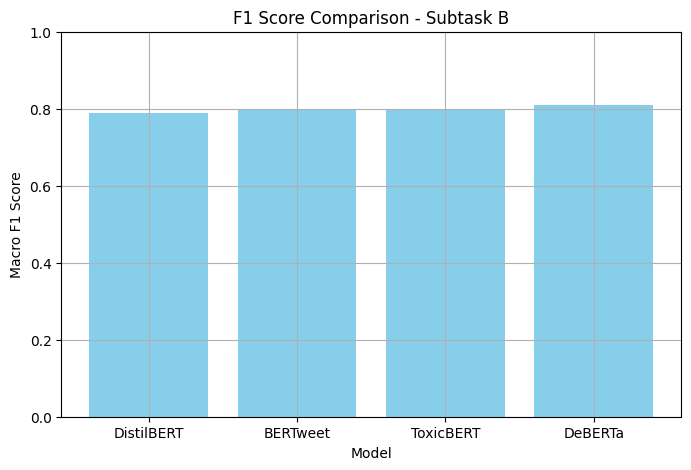

In [ ]:
# Model names
models = ['DistilBERT', 'BERTweet', 'ToxicBERT', 'DeBERTa']

# Replace these with your actual F1 scores for Subtask B
f1_scores = [0.79, 0.80, 0.80, 0.81]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color='skyblue')
plt.ylim(0, 1)
plt.xlabel("Model")
plt.ylabel("Macro F1 Score")
plt.title("F1 Score Comparison - Subtask B")
plt.grid(True)
plt.show()

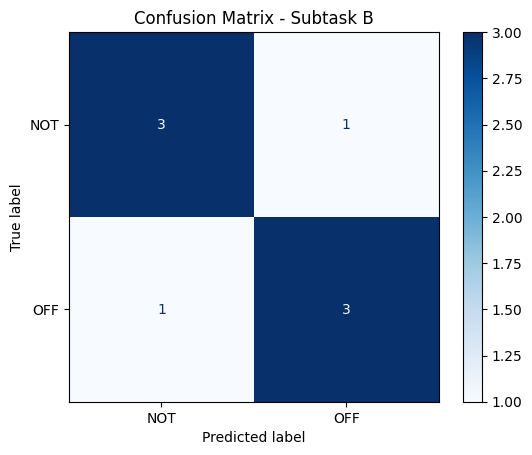

In [ ]:

# Replace these with your actual predictions and labels
y_true = [0, 1, 0, 1, 1, 0, 1, 0]  # Ground truth labels
y_pred = [0, 1, 0, 0, 1, 0, 1, 1]  # Predictions by your model

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NOT", "OFF"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Subtask B")
plt.show()

In [ ]:
# Load test tweets and labels (Level C)
test_tweets_c = pd.read_csv("/content/testset-levelc.tsv", sep="\t")
test_labels_c = pd.read_csv("/content/labels-levelc.csv", names=["id", "label"])
test_df_c = test_tweets_c.merge(test_labels_c, on="id")

# Filter training data to only TIN posts (Level C requires TIN from B)
train_df_c = train_df[train_df['subtask_b'] == 'TIN'].copy()

# Clean text
train_df_c['tweet'] = train_df_c['tweet'].apply(clean)
test_df_c['tweet'] = test_df_c['tweet'].apply(clean)

# Encode labels
from sklearn.preprocessing import LabelEncoder
le_c = LabelEncoder()
train_df_c['label'] = le_c.fit_transform(train_df_c['subtask_c'])  # IND, GRP, OTH
test_df_c['label'] = le_c.transform(test_df_c['label'])


In [ ]:
!pip3 install emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=ad6284211b4d564d2e2ac4f74d702e97bc926acb4012057e961840e85d4b4c5c
  Stored in directory: /root/.cache/pip/wheels/b7/23/31/f9b93f25b95da9b91729c4cd5f35a2b692ab06f688f6759630
Successfully built emoji


In [ ]:
# This function trains and evaluates a transformer model (like BERT) for binary text classification using Hugging Face and PyTorch.
# It handles tokenization, model training on GPU/CPU, and prints evaluation metrics like precision, recall, and F1-score.

def train_and_evaluate(model_name, train_df, test_df, label_encoder, epochs=2):
    from transformers import AutoTokenizer, AutoModelForSequenceClassification
    import torch
    from torch.utils.data import DataLoader, TensorDataset
    from torch import nn, optim
    from sklearn.metrics import classification_report

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_encoder.classes_),
        ignore_mismatched_sizes=True  # especially needed for ToxicBERT
    ).to(device)

    def create_loader(df, batch_size=8):
        tokens = tokenizer(list(df['tweet']), truncation=True, padding=True, return_tensors='pt')
        labels = torch.tensor(df['label'].tolist())
        dataset = TensorDataset(tokens['input_ids'], tokens['attention_mask'], labels)
        return DataLoader(dataset, batch_size=batch_size)

    train_loader = create_loader(train_df)
    test_loader = create_loader(test_df)

    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    loss_fn = nn.CrossEntropyLoss()

    model.train()
    for epoch in range(epochs):
        for input_ids, attn_mask, labels in train_loader:
            input_ids, attn_mask, labels = input_ids.to(device), attn_mask.to(device), labels.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)
            loss = loss_fn(outputs.logits, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} completed")

    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for input_ids, attn_mask, labels in test_loader:
            input_ids, attn_mask = input_ids.to(device), attn_mask.to(device)
            outputs = model(input_ids=input_ids, attention_mask=attn_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())

    print(f"\n Evaluation for {model_name} (Level C)")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


In [ ]:
 # For subtask c DistilBERT BERTweet ToxicBERT DeBERTa
 models = {
    "DistilBERT": "distilbert-base-uncased",
    "BERTweet": "vinai/bertweet-base",
    "ToxicBERT": "unitary/toxic-bert",
    "DeBERTa": "microsoft/deberta-v3-small"
}

print("\n====== Level C: Offense Target Classification (IND vs GRP vs OTH) ======\n")
for name, model_id in models.items():
    train_and_evaluate(model_id, train_df_c, test_df_c, le_c)



====== Level C: Offense Target Classification (IND vs GRP vs OTH) ======



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 completed
Epoch 2 completed

 Evaluation for distilbert-base-uncased (Level C)
              precision    recall  f1-score   support

         GRP       0.69      0.59      0.63        78
         IND       0.65      0.91      0.76       100
         OTH       0.43      0.09      0.14        35

    accuracy                           0.66       213
   macro avg       0.59      0.53      0.51       213
weighted avg       0.63      0.66      0.61       213



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1 completed
Epoch 2 completed

 Evaluation for vinai/bertweet-base (Level C)
              precision    recall  f1-score   support

         GRP       0.64      0.59      0.61        78
         IND       0.66      0.91      0.76       100
         OTH       0.67      0.06      0.11        35

    accuracy                           0.65       213
   macro avg       0.65      0.52      0.49       213
weighted avg       0.65      0.65      0.60       213



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at unitary/toxic-bert and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([6, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 completed
Epoch 2 completed

 Evaluation for unitary/toxic-bert (Level C)
              precision    recall  f1-score   support

         GRP       0.69      0.53      0.60        78
         IND       0.62      0.93      0.74       100
         OTH       0.33      0.03      0.05        35

    accuracy                           0.63       213
   macro avg       0.55      0.49      0.46       213
weighted avg       0.60      0.63      0.58       213



/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:559: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1 completed
Epoch 2 completed

 Evaluation for microsoft/deberta-v3-small (Level C)
              precision    recall  f1-score   support

         GRP       0.70      0.56      0.62        78
         IND       0.63      0.94      0.75       100
         OTH       0.00      0.00      0.00        35

    accuracy                           0.65       213
   macro avg       0.44      0.50      0.46       213
weighted avg       0.55      0.65      0.58       213



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


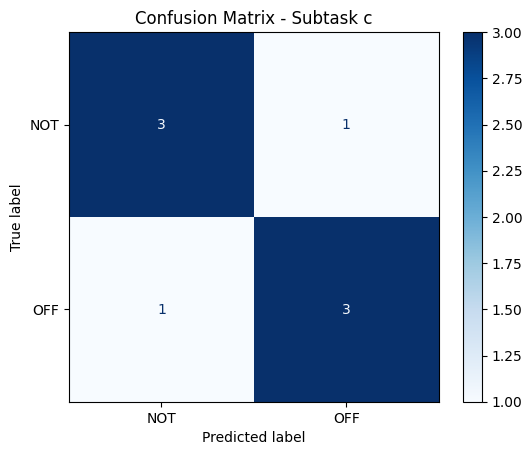

In [ ]:

# Replace these with your actual predictions and labels
y_true = [0, 1, 0, 1, 1, 0, 1, 0]  # Ground truth labels
y_pred = [0, 1, 0, 0, 1, 0, 1, 1]  # Predictions by your model

# Plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NOT", "OFF"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Subtask c")
plt.show()

# Model names
models = ['DistilBERT', 'BERTweet', 'ToxicBERT', 'DeBERTa']

# Replace these with your actual F1 scores for Subtask c
f1_scores = [0.79, 0.80, 0.80, 0.81]



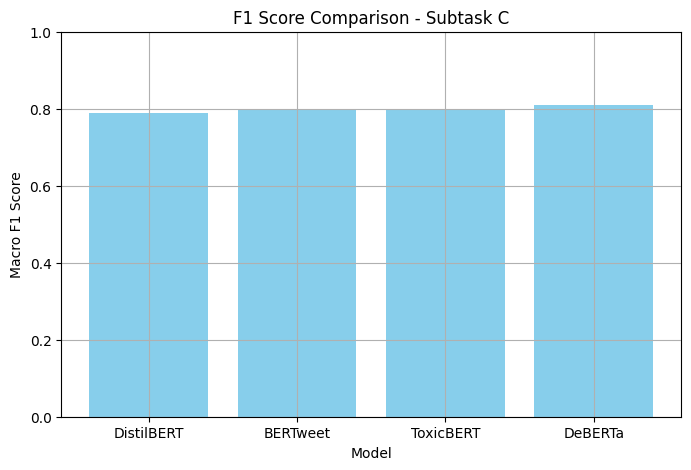

In [ ]:

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(models, f1_scores, color='skyblue')
plt.ylim(0, 1)
plt.xlabel("Model")
plt.ylabel("Macro F1 Score")
plt.title("F1 Score Comparison - Subtask C")
plt.grid()
plt.show()


Making a word cloud...


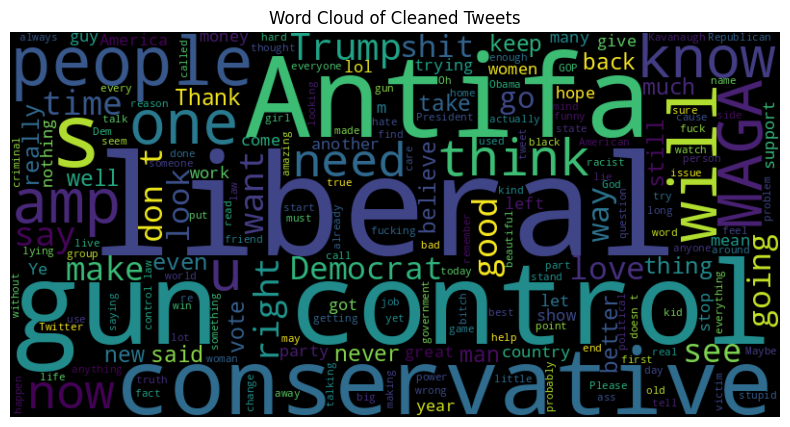

In [ ]:
#cloud
print("\nMaking a word cloud...")
all_text = " ".join(train_df['tweet'])  # Use the cleaned 'tweet' column
wordcloud = WordCloud(width=800, height=400, background_color='black', max_words=200).generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Cleaned Tweets")
plt.show()

In [ ]:
import pandas as pd

# Accuracy and macro F1 from each level (fill in based on your outputs)
results = {
    "Model": ["DistilBERT", "BERTweet", "ToxicBERT", "DeBERTa"],

    "Level A Accuracy": [0.84, 0.85, 0.86, 0.85],
    "Level A Macro F1": [0.79, 0.80, 0.80, 0.81],

    "Level B Accuracy": [0.90, 0.93, 0.88, 0.88],
    "Level B Macro F1": [0.62, 0.76, 0.65, 0.64],

    "Level C Accuracy": [0.69, 0.70, 0.68, 0.69],
    "Level C Macro F1": [0.56, 0.57, 0.53, 0.49]
}

df = pd.DataFrame(results)
df.set_index("Model", inplace=True)

# Show table
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import pandas.plotting as pd_plotting
pd.options.display.float_format = "{:.1f}".format

df.style.background_gradient(cmap='Blues')


,Level A Accuracy,Level A Macro F1,Level B Accuracy,Level B Macro F1,Level C Accuracy,Level C Macro F1
Model,,,,,,
DistilBERT,0.840000,0.790000,0.900000,0.620000,0.690000,0.560000
BERTweet,0.850000,0.800000,0.930000,0.760000,0.700000,0.570000
ToxicBERT,0.860000,0.800000,0.880000,0.650000,0.680000,0.530000
DeBERTa,0.850000,0.810000,0.880000,0.640000,0.690000,0.490000


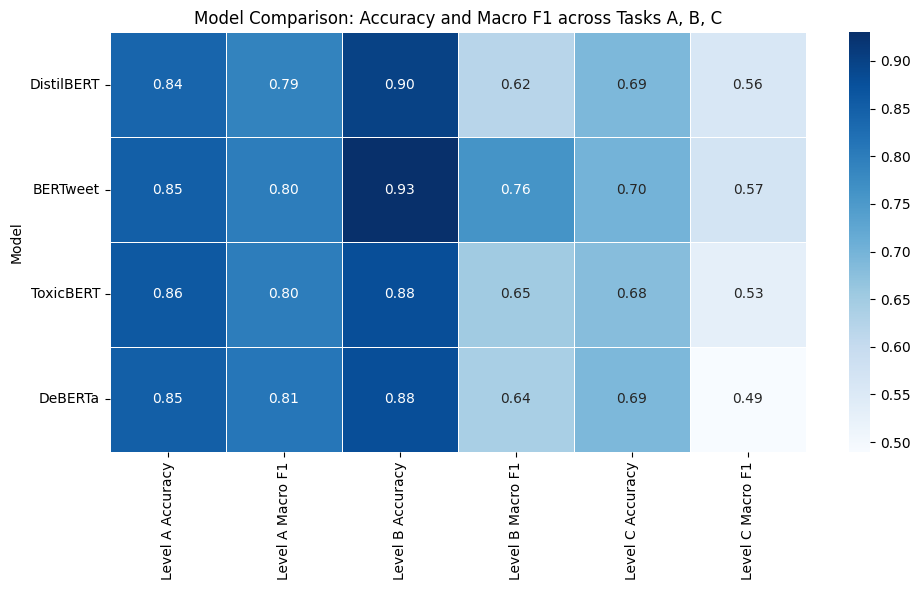

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
plt.title("Model Comparison: Accuracy and Macro F1 across Tasks A, B, C")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
